In [ ]:
TRACKING_SERVER_HOST = "" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [ ]:
https://www.kaggle.com/datasets/unsdsn/world-happiness

In [33]:
numerical = ['standard_error', 'economy_gdp_per_capita', 'family',
       'health_life_expectancy', 'freedom', 'trust_government_corruption',
       'generosity', 'dystopia_residual']
categorical = ['country', 'region']
numerical+categorical

['standard_error',
 'economy_gdp_per_capita',
 'family',
 'health_life_expectancy',
 'freedom',
 'trust_government_corruption',
 'generosity',
 'dystopia_residual',
 'country',
 'region']

In [154]:
import pandas as  pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import RobustScaler
import pickle


target = 'happiness_score'
'''numerical = ['economy_gdp_per_capita', 'family',
       'health_life_expectancy', 'freedom', 'trust_government_corruption',
       'generosity', 'dystopia_residual']'''
numerical = ['generosity']
#categorical = ['country', 'region']
categorical = ['region']

def dump_pickle(obj, filename: str):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)
    
def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)

def read(filename:str)->pd.DataFrame:
    "Load a parquet object from the file path, returning a DataFrame."
    df = pd.read_csv(f'../data/raw/{filename}')
    df.columns = df.columns.str.lower().str.replace("(","").str.replace(")","").str.replace(" ","_")

    return df

def prepare(df:pd.DataFrame, fit: bool = False)->pd.DataFrame:
    "Prepare a raw dataframe, returning a prepare DataFrame"
    df_copy =  df.copy()
    del df_copy['happiness_rank']
    
    if fit:
        dv = DictVectorizer()
        scaler = RobustScaler().set_output(transform="pandas")
        df_scaled = scaler.fit_transform(df_copy[numerical])
        
        dicts = df_copy[categorical].to_dict(orient='records')
        dv = DictVectorizer()
        ohe = pd.DataFrame(dv.fit_transform(dicts).todense(), columns=dv.feature_names_)
         
        df_prepare = pd.concat([ohe,df_scaled,df_copy[target]], axis=1)
        
        dump_pickle(dv,'../data/preprocess/dv.pkl')
        dump_pickle(scaler,'../data/preprocess/scaler.pkl')
        return df_prepare
        
    else:
        dv = load_pickle("../data/preprocess/dv.pkl")
        scaler = load_pickle("../data/preprocess/scaler.pkl")
        
        df_scaled = scaler.transform(df_copy[numerical])
        
        dicts = df_copy[categorical].to_dict(orient='records')
        ohe = pd.DataFrame(dv.transform(dicts).todense(), columns=dv.feature_names_)

        df_prepare = pd.concat([ohe,df_scaled,df_copy[target]], axis=1)
        return df_prepare
    
    
    

def train(df_train:pd.DataFrame, df_test:pd.DataFrame):
    
    X_train = df_train.drop(columns=target)
    X_test = df_test.drop(columns=target)
    
    y_train = df_train[target].values
    y_test = df_test[target].values

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    mse =mean_squared_error(y_test, y_pred, squared=False)
    
    return mse 

In [169]:
raw_data_2015 = read('2015.csv')
raw_data_2016  = read('2016.csv')


In [156]:
prepare_data_2015 = prepare(raw_data_2015,fit=True)
prepare_data_2016 = prepare(raw_data_2016,fit=False)

In [157]:
scaler = load_pickle("../data/preprocess/scaler.pkl")
scaler.feature_names_in_

array(['generosity'], dtype=object)

In [158]:
dv = load_pickle("../data/preprocess/dv.pkl")
dv.feature_names_

['region=Australia and New Zealand',
 'region=Central and Eastern Europe',
 'region=Eastern Asia',
 'region=Latin America and Caribbean',
 'region=Middle East and Northern Africa',
 'region=North America',
 'region=Southeastern Asia',
 'region=Southern Asia',
 'region=Sub-Saharan Africa',
 'region=Western Europe']

In [159]:
train(prepare_data_2015,prepare_data_2015)

0.7285142081955036

In [160]:
train(prepare_data_2015,prepare_data_2016)

0.7078153497678884

<Axes: ylabel='Frequency'>

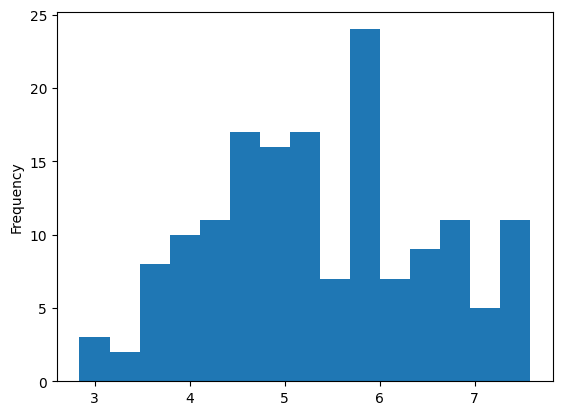

In [22]:
df_train['happiness_score'].plot.hist(bins=15)

In [100]:
train(prepare_data_2015,prepare_data_2015)

KeyError: "['country', 'region'] not in index"

0.8174997785535861

In [17]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse =mean_squared_error(y_test, y_pred, squared=False)

,Family,Health (Life Expectancy),Freedom
0,1.34951,0.94143,0.66557
1,1.40223,0.94784,0.62877
2,1.36058,0.87464,0.64938
3,1.33095,0.88521,0.66973
4,1.32261,0.90563,0.63297
...,...,...,...
153,0.77370,0.42864,0.59201
154,0.35386,0.31910,0.48450
155,0.47489,0.72193,0.15684
156,0.41587,0.22396,0.11850


In [14]:
df.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')